In [1]:
import sys
sys.path.append('../')
import ismrmrd
import numpy as np
import h5py
import rtoml
from ui.selectionui import get_selection
import os
import fnmatch
import matplotlib.pyplot as plt
%matplotlib widget
from mpl_interactions import image_segmenter
from pilottone.pt import get_volt_from_protoname


In [2]:
def readframe_from_mrd(filename, frame_list: list[int]) -> np.ndarray:
    with h5py.File(filename, 'r') as d:
        dset_names = list(d.keys())
        print(f'File {filename} contains {len(dset_names)} groups (reconstruction runs):')
        print(' ', '\n  '.join(dset_names))

    if len(dset_names) > 1:
        group = get_selection(dset_names)
    else:
        group = dset_names[0]

    with ismrmrd.Dataset(filename, group, False) as dset:
        subgroups = dset.list()
        imgGroups = [group for group in list(subgroups) if (group.find('image_') != -1)]
        imgGrp = imgGroups[0]
        img = []
        for frame_idx in frame_list:
            frame = dset.read_image(imgGrp, frame_idx)
            img.append(np.squeeze(frame.data))
    return np.array(img)

def centered_crop(img, crop_size):
    crop_size = np.array(crop_size)
    img_shape = np.array(img.shape)
    crop_start = (img_shape - crop_size) // 2
    crop_end = crop_start + crop_size
    return img[crop_start[0]:crop_end[0], crop_start[1]:crop_end[1]]

In [3]:
# Read config

with open('../config.toml', 'r') as cf:
    cfg = rtoml.load(cf)

DATA_DIR = 'vol0982_20240925'#cfg['data_folder']
output_dir = '../output_recons'
raw_files = ['287', '289', '291', '293', '295', '297', '299', '301', '303', '305', '319', '321', '323']
selected_frame = np.arange(20, 80)

volts = []

im_ref_fn = fnmatch.filter(os.listdir(f'{output_dir}/{DATA_DIR}'), f"viewsharing_*{'285'}*.mrd")[0]
im_ref = np.flip(np.rot90(readframe_from_mrd(f'{output_dir}/{DATA_DIR}/{im_ref_fn}', selected_frame), -1, axes=(1, 2)), axis=1)
im_editer = []
im_mdlsub = []
for raw_file_ in raw_files:
    raw_file = fnmatch.filter(os.listdir(f'{output_dir}/{DATA_DIR}'), f'viewsharing_*{raw_file_}*_mdlsub.mrd')[0]
    volts.append(get_volt_from_protoname(raw_file.split('/')[-1]))
    im_mdlsub.append(np.flip(np.rot90(readframe_from_mrd(f'{output_dir}/{DATA_DIR}/{raw_file}', selected_frame), -1, axes=(1, 2)), axis=1))
    raw_file = fnmatch.filter(os.listdir(f'{output_dir}/{DATA_DIR}'), f'viewsharing_*{raw_file_}*_editer.mrd')[0]
    im_editer.append(np.flip(np.rot90(readframe_from_mrd(f'{output_dir}/{DATA_DIR}/{raw_file}', selected_frame), -1, axes=(1, 2)), axis=1))

im_visual_fn = fnmatch.filter(os.listdir(f'{output_dir}/{DATA_DIR}'), f"viewsharing_*{'284'}*.mrd")[0]
im_visual = np.flip(np.rot90(readframe_from_mrd(f'{output_dir}/{DATA_DIR}/{im_visual_fn}', selected_frame), -1, axes=(1, 2)), axis=1)

File ../output_recons/vol0982_20240925/viewsharing_meas_MID00285_FID24232_pulseq2D_fire_spiralga_noPT_noRF_reference.mrd contains 1 groups (reconstruction runs):
  viewsharing_2024-10-03 12:17:53.182093
File ../output_recons/vol0982_20240925/viewsharing_meas_MID00287_FID24234_pulseq2D_fire_spiralga_10mV_24MHz_noRF_mdlsub.mrd contains 1 groups (reconstruction runs):
  viewsharing_2024-10-03 10:06:31.277766
File ../output_recons/vol0982_20240925/viewsharing_meas_MID00287_FID24234_pulseq2D_fire_spiralga_10mV_24MHz_noRF_editer.mrd contains 1 groups (reconstruction runs):
  viewsharing_2024-10-03 10:06:24.453926
File ../output_recons/vol0982_20240925/viewsharing_meas_MID00289_FID24236_pulseq2D_fire_spiralga_20mV_24MHz_noRF_mdlsub.mrd contains 1 groups (reconstruction runs):
  viewsharing_2024-10-03 10:09:00.128647
File ../output_recons/vol0982_20240925/viewsharing_meas_MID00289_FID24236_pulseq2D_fire_spiralga_20mV_24MHz_noRF_editer.mrd contains 1 groups (reconstruction runs):
  viewsharing_

/server/home/btasdelen/micromamba/envs/pilottone/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/server/home/btasdelen/micromamba/envs/pilottone/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


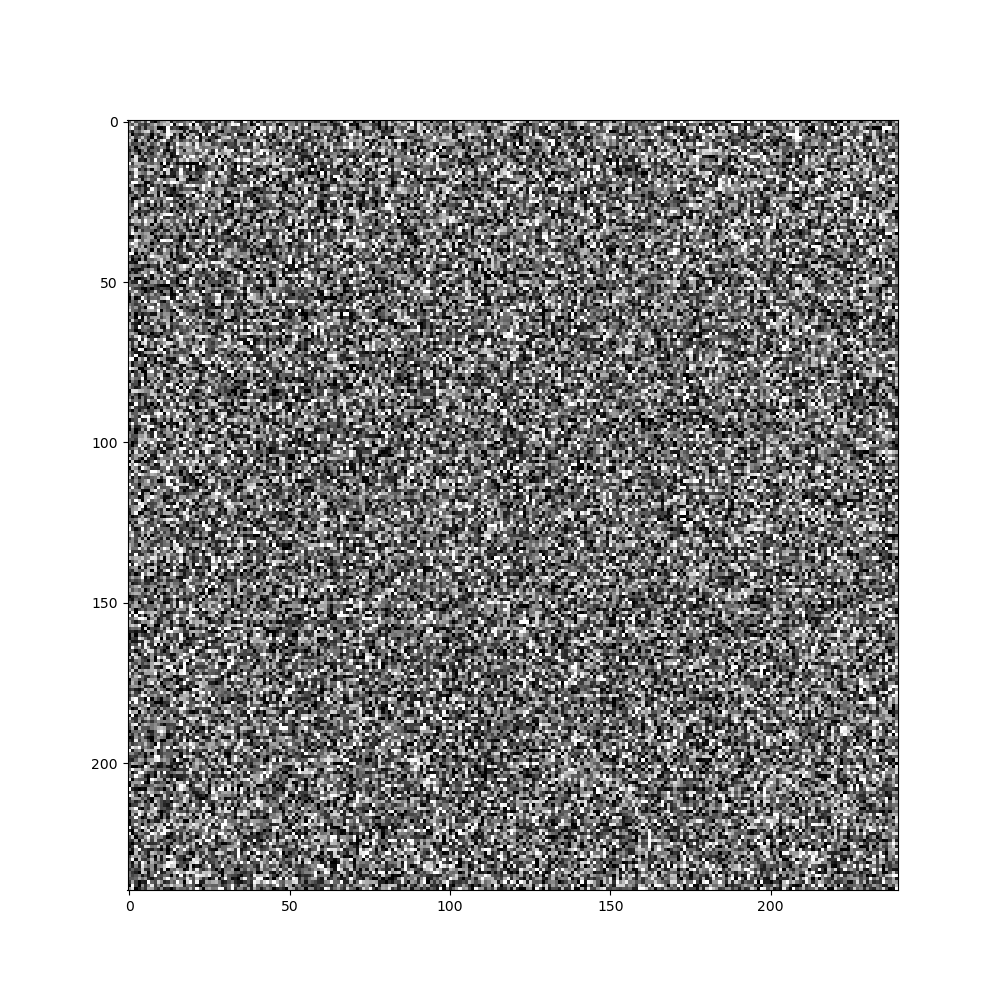

In [ ]:
import ipywidgets as widgets

vmin = np.percentile(np.abs(im_ref), 5)
vmax = np.percentile(np.abs(im_ref), 95)

N_classes = 2
class_selector = widgets.Dropdown(options=['noise', 'signal'], description="class")


def update(change):
    multi_class_segmenter.current_class = class_selector.index+1
    multi_class_segmenter.erasing = erasing_button.value


erasing_button = widgets.Checkbox(value=False, description="Erasing")
erasing_button.observe(update, names="value")
class_selector.observe(update, names="value")
props = {"color": "red", "linewidth": 4}
multi_class_segmenter = image_segmenter(np.abs(im_ref[0,:,:].squeeze()), nclasses=2, mask_alpha=0.76, vmin=vmin, vmax=vmax, cmap='gray', props=props)
multi_class_segmenter.current_class = 1

display(widgets.HBox([erasing_button, class_selector]))
display(multi_class_segmenter)


noise_mask = np.tile(multi_class_segmenter.mask == 1, (len(selected_frame), 1, 1))
signal_mask = np.tile(multi_class_segmenter.mask == 2, (len(selected_frame), 1, 1))


/server/home/btasdelen/workspace/PyPilotTone/venv/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


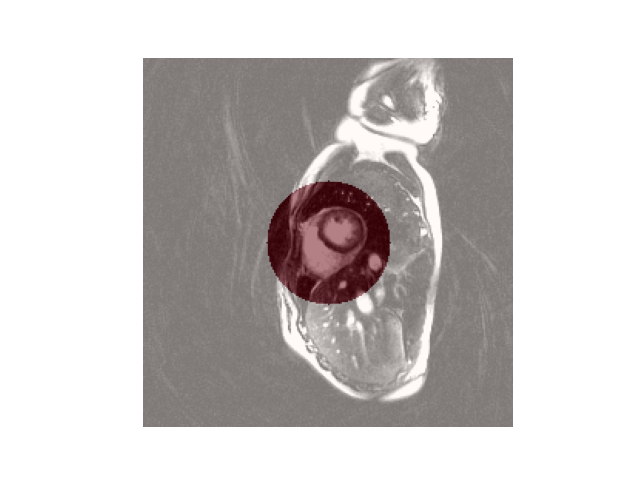

In [4]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

noise_mask = create_circular_mask(im_ref.shape[1], im_ref.shape[2], radius=40)
noise_mask = np.tile(noise_mask[None,:,:], (len(selected_frame), 1, 1))
signal_mask = noise_mask.copy()
plt.figure()
plt.imshow(np.abs(im_visual[10,:,:]), 
           vmin=np.percentile(np.abs(im_visual[10,:,:]),5), 
           vmax=np.percentile(np.abs(im_visual[10,:,:]),95), 
           cmap='gray')
plt.axis('off')
plt.imshow(noise_mask[0,:,:], alpha=0.5, cmap='Reds')

/server/home/btasdelen/workspace/PyPilotTone/venv/lib/python3.10/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/server/home/btasdelen/workspace/PyPilotTone/venv/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


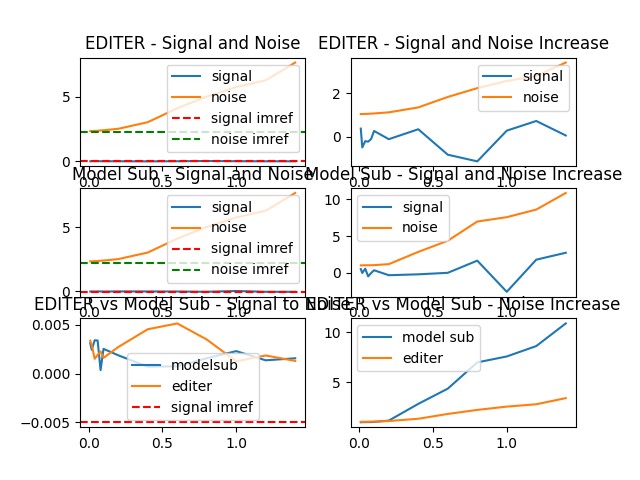

In [5]:


from math import sqrt
import datetime

signal_pixels_editer = [(im[signal_mask]) for im in im_editer]
noise_pixels_editer = [(im[noise_mask]) for im in im_editer]

signal_pixels_modelsub = [(im[signal_mask]) for im in im_mdlsub]
noise_pixels_modelsub = [(im[noise_mask]) for im in im_mdlsub]

signal_pixels_imref = (im_ref[signal_mask])
noise_pixels_imref = (im_ref[noise_mask])

mean_signal_editer = np.mean(signal_pixels_editer, axis=1)
mean_noise_editer = np.std(noise_pixels_editer, axis=1)*sqrt(2/np.pi)

mean_signal_modelsub = np.mean(signal_pixels_modelsub, axis=1)
mean_noise_modelsub = np.std(noise_pixels_modelsub, axis=1)*sqrt(2/np.pi)

mean_signal_imref = np.mean(signal_pixels_imref)
mean_noise_imref = np.std(noise_pixels_imref)*sqrt(2/np.pi)

f, axs = plt.subplots(3,2)
axs[0,0].plot(volts, mean_signal_editer, label='signal')
axs[0,0].plot(volts, mean_noise_editer, label='noise')
axs[0,0].axhline(mean_signal_imref, color='r', linestyle='--', label='signal imref')
axs[0,0].axhline(mean_noise_imref, color='g', linestyle='--', label='noise imref')
axs[0,0].legend()
axs[0,0].set_title('EDITER - Signal and Noise')

axs[0,1].plot(volts, mean_signal_editer/mean_signal_imref, label='signal')
axs[0,1].plot(volts, mean_noise_editer/mean_noise_imref, label='noise')
axs[0,1].legend()
axs[0,1].set_title('EDITER - Signal and Noise Increase')

axs[1,0].plot(volts, mean_signal_modelsub, label='signal')
axs[1,0].plot(volts, mean_noise_editer, label='noise')
axs[1,0].axhline(mean_signal_imref, color='r', linestyle='--', label='signal imref')
axs[1,0].axhline(mean_noise_imref, color='g', linestyle='--', label='noise imref')
axs[1,0].legend()
axs[1,0].set_title('Model Sub - Signal and Noise')

axs[1,1].plot(volts, mean_signal_modelsub/mean_signal_imref, label='signal')
axs[1,1].plot(volts, mean_noise_modelsub/mean_noise_imref, label='noise')
axs[1,1].legend()
axs[1,1].set_title('Model Sub - Signal and Noise Increase')

axs[2,0].plot(volts, np.abs(mean_signal_modelsub/mean_noise_modelsub), label='modelsub')
axs[2,0].plot(volts, np.abs(mean_signal_editer/mean_noise_editer), label='editer')
axs[2,0].axhline(mean_signal_imref/mean_noise_imref, color='r', linestyle='--', label='signal imref')
axs[2,0].legend()
axs[2,0].set_title('EDITER vs Model Sub - Signal to Noise')

axs[2,1].plot(volts, np.abs(mean_noise_modelsub/mean_noise_imref), label='model sub')
axs[2,1].plot(volts, np.abs(mean_noise_editer/mean_noise_imref), label='editer')
axs[2,1].legend()
axs[2,1].set_title('EDITER vs Model Sub - Noise Increase')

plt.show()

np.savez(os.path.join(output_dir, DATA_DIR, f'noise_{datetime.datetime.now()}.npz'), mean_noise_editer=mean_noise_editer, mean_noise_modelsub=mean_noise_modelsub, mean_noise_imref=mean_noise_imref, volts=volts) 